In [ ]:
# You will need to run this block twice to make it effective
!apt-get update 
!apt-get install cmake 
!pip install --upgrade setuptools 
!pip install ez_setup 
#!pip install gym[atari]
#!pip install box2d-py 
!pip install gym==0.24.1
!pip install gym[all]

#!pip install gym[all] 
#!pip install pyglet
#!pip install gym[box2d]



!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg 

In [2]:
from torch._C import dtype
import gym
#from gym.envs.box2d import car_racing
#from gym.wrappers import Monitor
from gym.wrappers.monitoring import video_recorder
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.distributions.beta import Beta
import numpy as np
import copy
from collections import deque
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

from torch import randint
from time import sleep
import pickle
import statistics as st
from gym.core import RewardWrapper
import gc

import os

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)


display = Display(visible=0, size=(1400, 900))
display.start()


def get_speed(image):
    subimage = (image[84:96,13:14]-0.495)*10
    speed = np.sum(subimage)
    return speed

def process_image(image):
    red = image[:,:,0:1]*0.55
    green = image[:,:,1:2]*-0.45 + 255*0.495
    image = np.squeeze(red+green)/255
    image[image<0.4] = 0
    return image

def plot_image(array):
    plt.imshow(array, cmap='gray', vmin=0, vmax=1)
    plt.show()


class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorCriticNetwork(nn.Module):
    def __init__(self,alpha):
        super(ActorCriticNetwork, self).__init__()

        #layers
        self.LeakyReLU = nn.LeakyReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Softplus = nn.Softplus()
        self.conv1 = nn.Conv2d(1,8,kernel_size = 7, stride = 4,padding = 0)
        self.conv2 = nn.Conv2d(8,16,kernel_size = 3, stride = 1,padding = 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(577,512)
        self.fcc2 = nn.Linear(512,1)
        self.fca2 = nn.Linear(512,512)
        self.fca3 = nn.Linear(512,2)
        #self.batchnormCNN1 = nn.BatchNorm2d(num_features = 8)
        #self.batchnormCNN2 = nn.BatchNorm2d(num_features = 16)
        #self.batchnormFC1 = nn.BatchNorm1d(num_features = 256)
        self.flatten = nn.Flatten()


        self.checkpoint_file =  'actor_critic_torch_ppo'
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, x):
        # reformat image (input = BS,96,96, or 96,96) (output = BS,1,96,96)
        x = torch.from_numpy(np.ascontiguousarray(x)).float()
        if(x.dim()==2):
          x = torch.unsqueeze(x,dim=0)
          x = torch.unsqueeze(x,dim=0)
        elif(x.dim()==3):
          x = torch.unsqueeze(x,dim=1)
        subimage = (x[:,:,84:96,13:14]-0.495)*10
        speed = torch.sum(subimage,dim=(2,3))
        x = x[:,:,:84,:]
        
        '''Shared weights'''
        #print(x.shape)
        x = self.LeakyReLU(self.conv1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.LeakyReLU(self.conv2(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = torch.cat((x,speed),dim=1)
        x = self.LeakyReLU(self.fc1(x))
        '''Actor and Critic Diverge'''
        #print("actor forward")
        #print(dist.shape)
        dist = self.LeakyReLU(self.fca2(x))
        #print(dist.shape)
        dist = self.Softplus(self.fca3(x))
        #print(dist)
        #print(dist.shape)
        dist = torch.swapaxes(dist,0,1)
        #print(dist)
        #print(dist.shape)
        dist = Beta(dist[0],dist[1])
        #print("value forward")
        value = self.fcc2(x)
        #print(value)
        
        return dist, value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))


class Agent:
    def __init__(self, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor_critic = ActorCriticNetwork(alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models...')
        self.actor_critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_checkpoint()

    def choose_action(self, observation):
        self.actor_critic.eval()
        state = torch.tensor([observation], dtype=torch.float).to(self.actor_critic.device)

        dist,value = self.actor_critic(state)
        action = dist.sample()

        probs = torch.squeeze(torch.exp(dist.log_prob(action))).item() 
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        self.actor_critic.train()
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            # Monte Carlo Rewards/ Advantage
            '''
            returns = np.zeros(len(rew_arr)), dtype=np.float32)
            rew = 0
            for t in range(len(reward_arr)-1,-1,-1):
                rew+=reward_arr[t]
                returns[t] = rew
                rew = rew*self.gamma
            _,values = self.actor_critic(state_arr)
            values = torch.squeeze(values)

            advantage = returns - values
            advantage = torch.tensor(advantage).to(self.actor_critic.device)
            '''
            # Advantage Bootsrapped on A = V(s)+r - decay*V(s+1) for varios depths
            values = vals_arr
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor_critic.device)


            
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor_critic.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor_critic.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor_critic.device)

                dist, critic_value = self.actor_critic(states)
                critic_value = torch.squeeze(critic_value)

                new_probs = torch.exp(dist.log_prob(actions))
                prob_ratio = new_probs/ old_probs
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                #print("loss",total_loss)
                self.actor_critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor_critic.optimizer.step()

        self.memory.clear_memory()               

ModuleNotFoundError: ignored

In [ ]:
def simulate():
    env = wrap_env(gym.make("CarRacing-v1"),render = True)
    agent = Agent()
    agent.load_models()
    observation = env.reset()
    done = False
    score = 0
    #skip first few useless episodes
    state, reward, done, info = env.skip_episodes(70,[0,0.1,0])
    while not done:
        action, prob, val = agent.choose_action(state)
        next_state, reward, done, info = env.step([action*2 - 1,0.1,0])
        score += reward
        state = next_state
    print("score",reward,"ep_len",env.ep_len)
    env.env.close()
    show_video()

In [ ]:
if __name__ == '__main__':
    env = wrap_env(gym.make("CarRacing-v1").unwrapped)
    #env = wrap_env(CarRacing().unwrapped)
    #N = 5
    #lr = 0.0003
    #n_epochs=4
    agent = Agent(batch_size=50,alpha=0.00005, n_epochs=4, gamma = 0.92, gae_lambda=0.95, policy_clip = 0.2)
    #agent.load_models()
    n_games = 200

    figure_file = 'plots/car-racing.png'

    best_score = env.env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0

        #skip first few useless episodes
        state, reward, done, info = env.skip_episodes(70,[0,0.1,0])

        while not done:
            action, prob, val = agent.choose_action(state)
            next_state, reward, done, info = env.step([action*2 - 1,0.1,0])
            #print(reward)
            n_steps += 1
            score += reward
            score = env.ep_len
            agent.remember(state, action, prob, val, reward, done)
            state = next_state
        agent.learn()
        learn_iters += 1  
        score_history.append(score)
        avg_score = np.mean(score_history[-20:])

        if avg_score > best_score and i>20:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

In [ ]:
simulate()

In [ ]:
show_video()

Could not find video


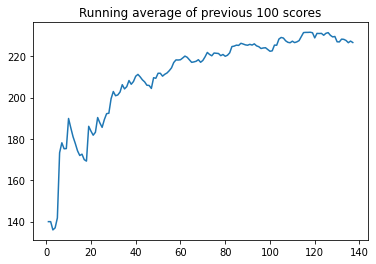

In [ ]:
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)